In [7]:
from picsellia import Client 
from picsellia.types.enums import LogType

In [8]:
import random
import os 
import shutil
import numpy as np 
import tqdm
import matplotlib.pyplot as plt
import cv2
import keras 
import albumentations as A 

2023-09-08 08:37:38.568836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 08:37:39.499914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [10]:
from picsellia import Experiment

In [11]:
def get_classes_from_mask_datasetversion(experiment: Experiment):
    mask_datasetversion = experiment.get_dataset(name="masks")
    labels = mask_datasetversion.list_labels()

    return labels

In [12]:
api_token = ""
client = Client(api_token=api_token)
experiment_id = "018a6558-2265-7771-ad23-d17268db152f"
experiment = client.get_experiment_by_id(experiment_id)

You are using an outdated version of the picsellia package (6.10.1)
Please consider upgrading to 6.10.2 with pip install picsellia --upgrade
Hi hajer, welcome back. 🥑
Workspace: your organization.


In [5]:
for datasetversion in experiment.list_attached_dataset_versions(): 
    print(datasetversion.version)

original
masks


In [167]:
datasetversions = [datasetversion.version for datasetversion in experiment.list_attached_dataset_versions()]

In [22]:
image_assets = experiment.get_dataset(name="original")
mask_assets = experiment.get_dataset(name="masks")

In [7]:
image_path = os.path.join(experiment.png_dir, "original")
mask_path = os.path.join(experiment.png_dir, "masks")

In [14]:
image_assets.download(target_path=image_path)

100%|█████████████████████████████████████████████████████████████| 999/999 [03:39<00:00,  4.55it/s]

999 assets downloaded (over 999) in directory test1/images/original
Assets of Version 'original' of dataset autopix  (id: 018a64b5-c3ce-7e44-a089-512c87a1f9a3) downloaded into test1/images/original


In [15]:
mask_assets.download(target_path=mask_path)

100%|███████████████████████████████████████████████████████████| 1000/1000 [03:52<00:00,  4.30it/s]

1000 assets downloaded (over 1000) in directory test1/images/masks
Assets of Version 'masks' of dataset autopix  (id: 018a64b7-7a59-7d98-a84f-1eca5b82dc8c) downloaded into test1/images/masks


In [8]:
image_files = os.listdir(path=image_path)
mask_files = os.listdir(path=mask_path)

In [12]:
random.Random(11).shuffle(image_files)
nbr_images = len(image_files)
train_images, eval_images, test_images = np.split(image_files, [int(nbr_images*0.8), int(nbr_images*0.9)])

In [28]:
x_train_dir = os.path.join(experiment.png_dir,"train-images")
y_train_dir = os.path.join(experiment.png_dir,"train-masks")

x_test_dir = os.path.join(experiment.png_dir, "test-images")
y_test_dir = os.path.join(experiment.png_dir, "test-masks")

x_eval_dir = os.path.join(experiment.png_dir, "eval-images")
y_eval_dir = os.path.join(experiment.png_dir, "eval-masks")



In [ ]:
os.makedirs(name=x_train_dir)
os.makedirs(name=y_train_dir)

os.makedirs(name=x_test_dir)
os.makedirs(name=y_test_dir)

os.makedirs(name=x_eval_dir)
os.makedirs(name=y_eval_dir)

In [6]:
def find_corresponding_mask(image_filename: str) -> str:
    base_filename = image_filename.split('- ')[1].split('.')[0]
    for mask_file in os.listdir(mask_path): 
        if base_filename in mask_file: 
            mask_filename = mask_file 
            break 
    return mask_filename

In [7]:
def change_mask_filename_to_match_image(mask_prefix: str, image_prefix:str, old_mask_filename: str) -> str: 
    new_mask_filename = image_prefix + old_mask_filename[len(mask_prefix):]

    return new_mask_filename


In [8]:
def move_images_and_masks(image_list: list[str], image_dir, mask_dir): 
    for image_filename in tqdm.tqdm(image_list):
        mask_filename = find_corresponding_mask(image_filename=image_filename)
        


        image_dest = os.path.join(image_dir, image_filename)
        mask_dest = os.path.join(mask_dir, change_mask_filename_to_match_image(mask_prefix="mask", image_prefix="orig",old_mask_filename=mask_filename))

        img_file_path = os.path.join(image_path,image_filename)
        mask_file_path = os.path.join(mask_path,mask_filename)

        shutil.copy(img_file_path,image_dest)
        shutil.copy(mask_file_path,mask_dest)

In [ ]:
move_images_and_masks(
    experiment=experiment,
    image_list=train_images,
    mask_list=mask_files,
    dest_image_dir=x_train_dir,
    dest_mask_dir=y_train_dir,
)

move_images_and_masks(
    experiment=experiment,
    image_list=test_images,
    mask_list=mask_files,
    dest_image_dir=x_test_dir,
    dest_mask_dir=y_test_dir,
)
move_images_and_masks(
    experiment=experiment,
    image_list=eval_images,
    mask_list=mask_files,
    dest_image_dir=x_eval_dir,
    dest_mask_dir=y_eval_dir,
)

In [126]:
# move_images_and_masks(image_list=train_images, image_dir= x_train_dir,mask_dir= y_train_dir)
# move_images_and_masks(image_list=test_images, image_dir= x_test_dir,mask_dir= y_test_dir)
# move_images_and_masks(image_list=eval_images, image_dir= x_eval_dir,mask_dir= y_eval_dir)

100%|██████████| 100/100 [00:00<00:00, 131.82it/s]


In [41]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['car']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0]+".png") for image_id in self.ids]

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [29]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

In [37]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

In [42]:
image, mask = dataset[7] # get some sample

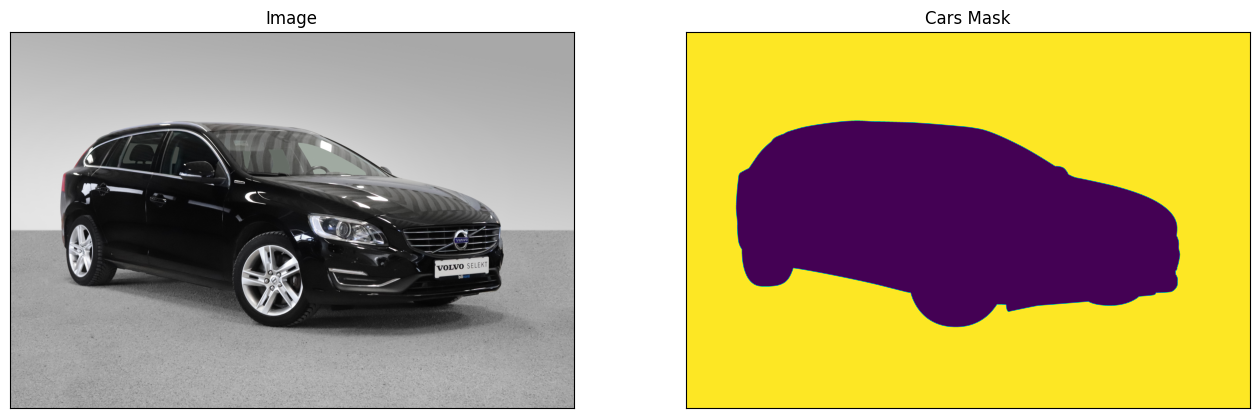

In [30]:

image, mask = dataset[7] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
)



## Augmentations

In [39]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

SIZE = 480

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.3),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.3, border_mode=0),
        A.Resize(SIZE,SIZE, p=1, always_apply=True),

        A.PadIfNeeded(min_height=SIZE, min_width=SIZE, always_apply=True, border_mode=0),
        # A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform, is_check_shapes=False)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # A.PadIfNeeded(384, 480)
        A.Resize(SIZE,SIZE, p=1, always_apply=True)
    ]
    return A.Compose(test_transform, is_check_shapes=False)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/home/ubuntu/dev/unet-project/.venv/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/ubuntu/dev/unet-project/.venv/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/ubuntu/dev/unet-project/.venv/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ubuntu/dev/unet-project/.venv/lib/python3.11/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is

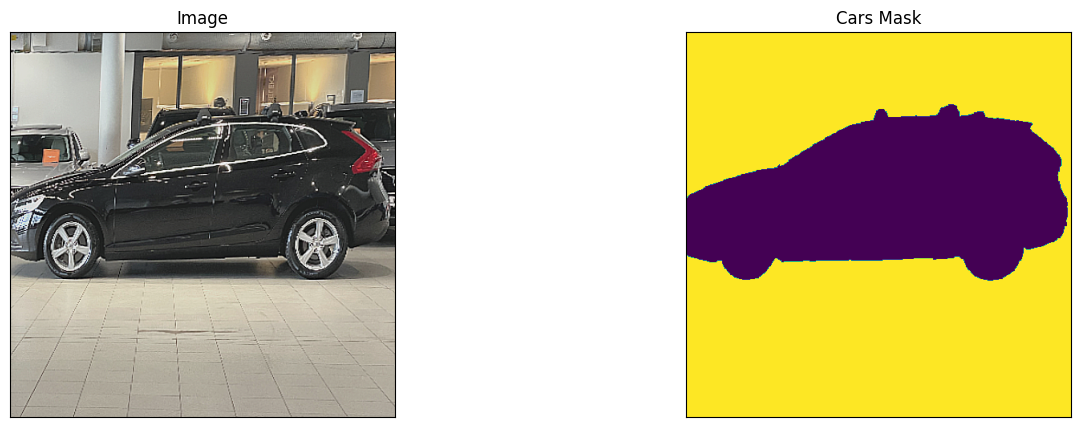

In [18]:


# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'], augmentation=get_training_augmentation())

image, mask = dataset[2] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze()
)



In [18]:
import segmentation_models as sm 
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = ['car']
LR = 0.0001
EPOCHS = 1


preprocess_input = sm.get_preprocessing(BACKBONE)
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'


Segmentation Models: using `tf.keras` framework.


In [20]:
import segmentation_models as sm 
BACKBONE = "efficientnetb3"
n_classes = 1
activation = 'sigmoid' if n_classes == 1 else 'softmax'
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,encoder_weights='imagenet' )

2023-09-07 15:17:58.713557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 15:17:58.761472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 15:17:58.761740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# model = sm.Unet('efficientnetb1', classes=n_classes, activation=activation,encoder_weights='/home/ubuntu/dev/unet-project/efficientnet-b1_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5' )

In [20]:


# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)



In [22]:
class LogTrainingMetrics(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("logs on_epoch_end: ", logs)
        for metric_name in logs.keys(): 
            experiment.log(name=metric_name, type=LogType.LINE, data=float(logs[metric_name]))

    # def on_train_batch_end(self, batch, logs=None):
    #     print("logs on_epoch_end: ", logs)
    #     for metric_name in logs.keys(): 
    #         experiment.log(name=metric_name, type=LogType.LINE, data=float(logs[metric_name]))


In [27]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

best_model_path = os.path.join(experiment.checkpoint_dir, 'best_model.h5')

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(best_model_path, save_weights_only=False, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    LogTrainingMetrics()
]

In [25]:
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, SIZE, SIZE, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, SIZE, SIZE, n_classes)

In [33]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

2023-09-07 15:46:26.011527: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


199/199 [==============================] - ETA: 0s - loss: 0.0823 - iou_score: 0.9572 - f1-score: 0.9779

/home/ubuntu/dev/unet-project/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


logs on_epoch_end:  {'loss': 0.08228661119937897, 'iou_score': 0.9571542143821716, 'f1-score': 0.9778693318367004, 'val_loss': 0.042387284338474274, 'val_iou_score': 0.9821044206619263, 'val_f1-score': 0.9906895160675049, 'lr': 1e-04}
199/199 [==============================] - 624s 3s/step - loss: 0.0823 - iou_score: 0.9572 - f1-score: 0.9779 - val_loss: 0.0424 - val_iou_score: 0.9821 - val_f1-score: 0.9907 - lr: 1.0000e-04


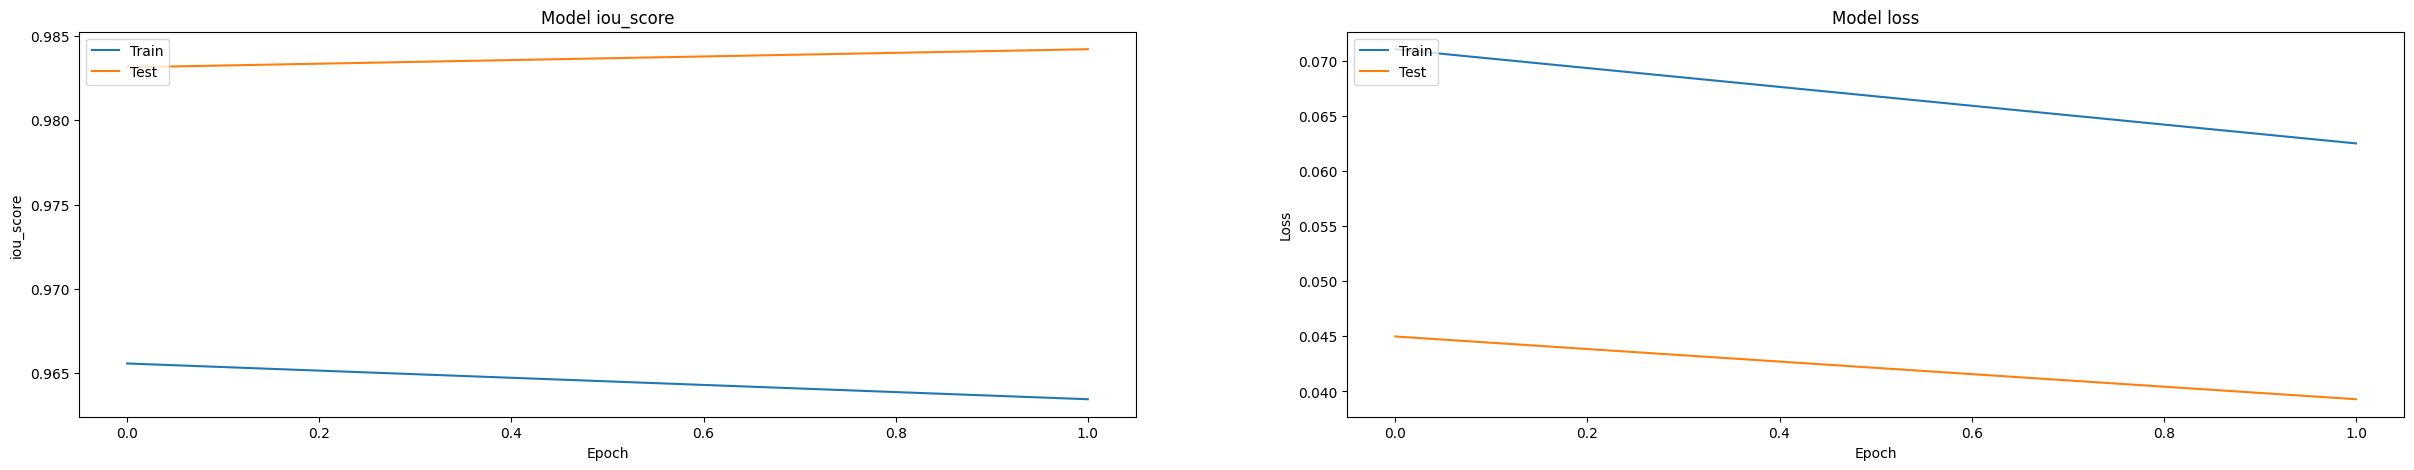

In [144]:


# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [ ]:
# log graphs and store model 
experiment.store("best_model", best_model_path)

## Model evaluation 


In [107]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

self.ids = ['orig - DS834.JPG', 'orig - DS758.JPG', 'orig - DS1278.jpg', 'orig - DS357.JPG', 'orig - DS971.JPG', 'orig - DS350.JPG', 'orig - DS719.jpg', 'orig - DS396.JPG', 'orig - DS957.JPG', 'orig - DS1231.jpg', 'orig - DS429.jpg', 'orig - DS696.jpg', 'orig - DS1030.jpg', 'orig - DS989.JPG', 'orig - DS759.JPG', 'orig - DS365.JPG', 'orig - DS798.JPG', 'orig - DS1140.JPG', 'orig - DS1110.jpg', 'orig - DS965.JPG', 'orig - DS1273.jpg', 'orig - DS640.jpg', 'orig - DS845.JPG', 'orig - DS568.JPG', 'orig - DS347.JPG', 'orig - DS1192.JPG', 'orig - DS1232.jpg', 'orig - DS1011.JPG', 'orig - DS614.JPG', 'orig - DS1248.jpg', 'orig - DS619.jpg', 'orig - DS673.JPG', 'orig - DS661.jpg', 'orig - DS1306.JPG', 'orig - DS1016.JPG', 'orig - DS841.JPG', 'orig - DS1264.jpg', 'orig - DS1115.JPG', 'orig - DS600.JPG', 'orig - DS1214.jpg', 'orig - DS701.jpg', 'orig - DS1165.jpg', 'orig - DS1005.JPG', 'orig - DS1310.JPG', 'orig - DS394.JPG', 'orig - DS1174.JPG', 'orig - DS775.jpg', 'orig - DS1017.JPG', 'orig - 

In [19]:
model= sm.Unet(BACKBONE, classes=n_classes, activation=activation) 
model.load_weights('/home/ubuntu/dev/unet-project/test1/checkpoint/best_model.h5')

2023-09-08 13:54:45.025152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 13:54:45.083817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 13:54:45.084122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [108]:
# load best weights
model.load_weights('best_model.h5') 

In [109]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/tmp/ipykernel_1847/3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.029537
mean iou_score: 0.98431
mean f1-score: 0.99181


In [160]:
eval_metrics = {}
eval_metrics["loss"] = float("{:.5f}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    eval_metrics[metric.__name__] = float("{:.5f}".format(value))
    # print("mean {}: {:.5}".format(metric.__name__, value))

In [162]:
experiment.log(name="eval-results", type=LogType.TABLE, data=eval_metrics)

Log eval-results (id: 018a6ad0-4eac-7b12-b2b6-97bc08198d40)

1/1 [==============================] - 3s 3s/step


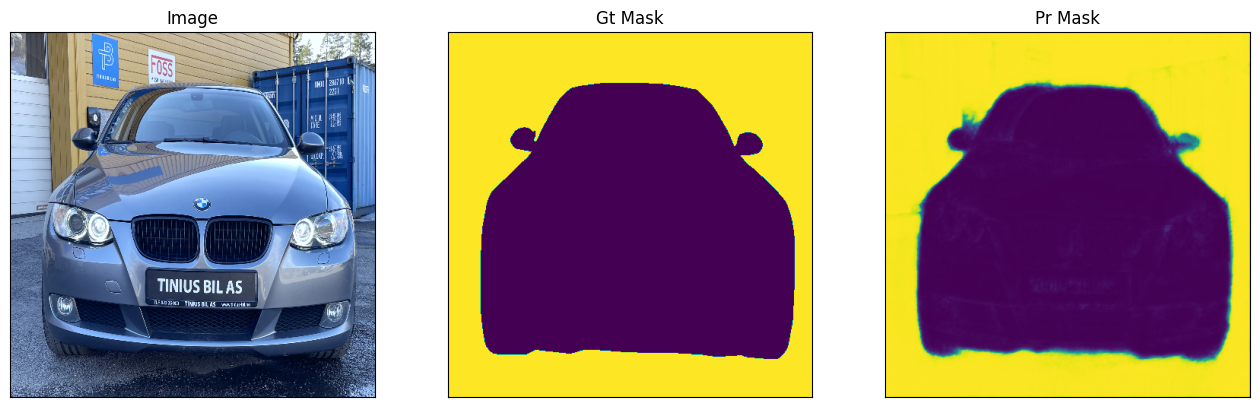

1/1 [==============================] - 0s 33ms/step


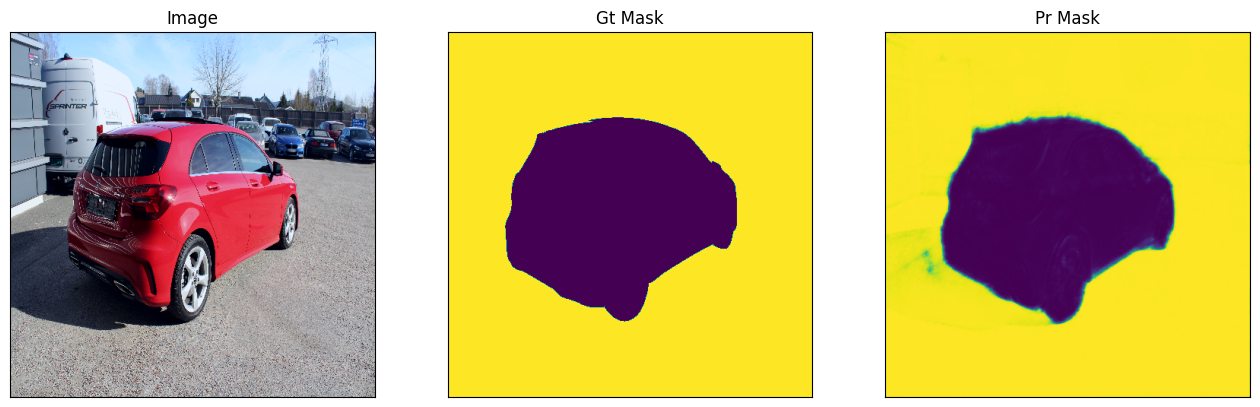

1/1 [==============================] - 0s 34ms/step


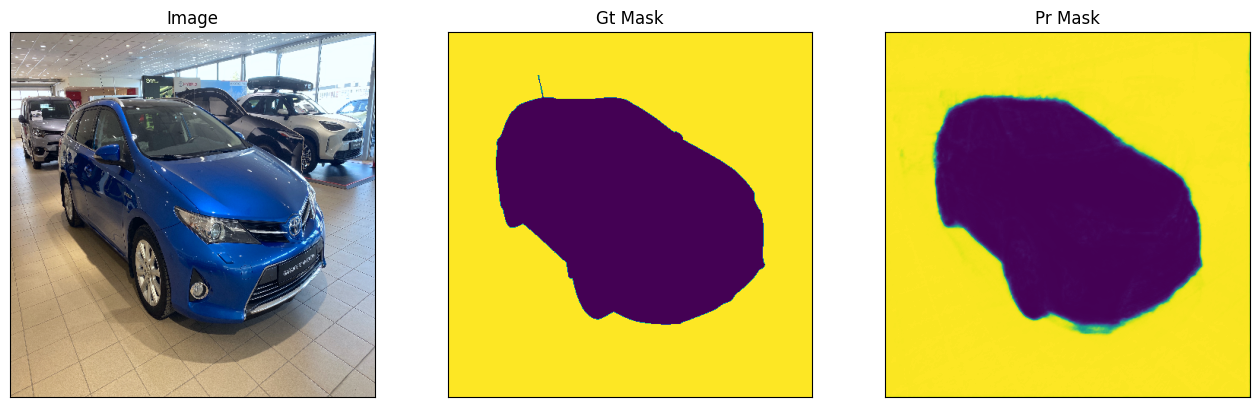

1/1 [==============================] - 0s 34ms/step


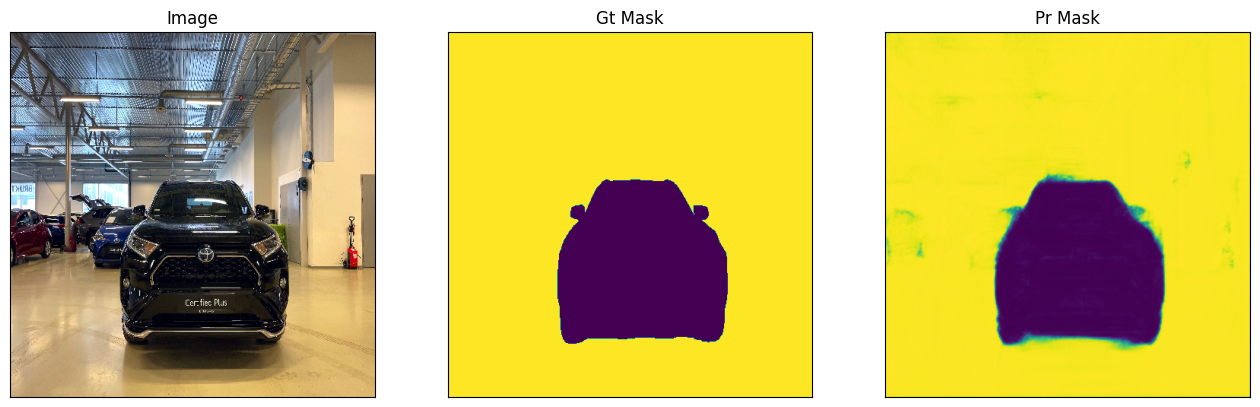

1/1 [==============================] - 0s 35ms/step


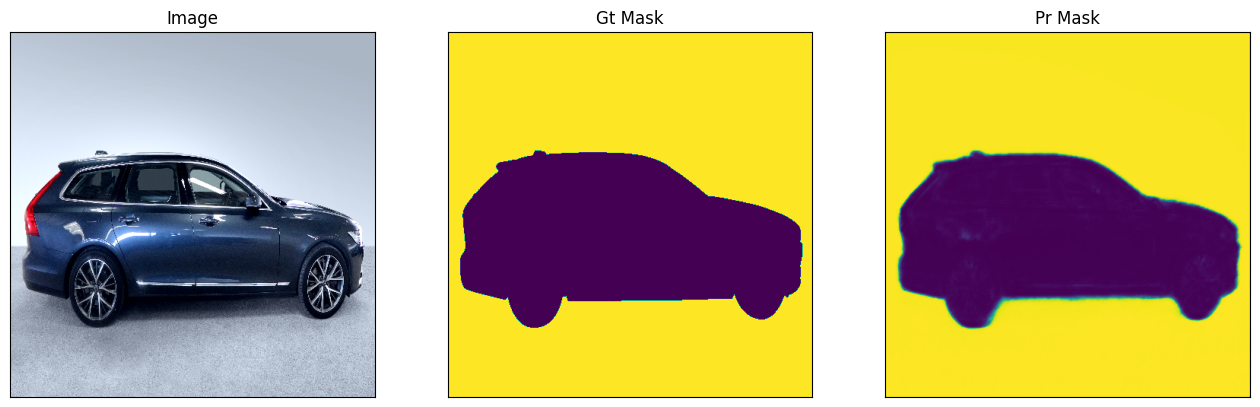

In [110]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

In [45]:
def _get_total_loss():
    dice_loss = sm.losses.DiceLoss()
    focal_loss = (
        sm.losses.BinaryFocalLoss()
    )
    total_loss = dice_loss + (1 * focal_loss)
    return total_loss
